In [128]:
#Dependencies
import pandas as pd
import numpy as np
import itertools

import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import matplotlib.pyplot as plt
import plotly.express as px

import time
import tqdm


ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')
STATE_SIZE = 10

In [129]:
# we will ignore pandas warning 
import warnings
warnings.filterwarnings('ignore')

In [130]:
def generate_int_id(dataframe, id_col_name):
    new_dataframe=dataframe.assign(
        int_id_col_name=np.arange(len(dataframe))
        ).reset_index(drop=True)
    return new_dataframe.rename(columns={'int_id_col_name': id_col_name})

In [131]:
ordersExport = pd.read_csv('orders_export.csv')
productsExport = pd.read_csv('products_export.csv')

In [132]:
df_order = ordersExport[['Name', 'Lineitem quantity', 'Lineitem name', 'Lineitem sku']]
print(df_order.shape)
df_order.head()

(118, 4)


,Name,Lineitem quantity,Lineitem name,Lineitem sku
0,#2891,1,Betwa Kurta - XL,HOD0011
1,#2891,1,Bhagirathi pants - XXL,HOD0444
2,#2891,1,Kosi Kurta - XL,HOD0005
3,#2892,1,Panzara kurta - XXL,HOD0126
4,#2893,1,Betwa Kurta - S,HOD0008


In [133]:
productsExport = productsExport[productsExport['Tags'].isnull() == False]
productsExport = productsExport[productsExport['Published'] == True]
print(productsExport.shape)
productsExport.head(2)

(134, 49)


,Handle,Title,Body (HTML),Vendor,Standardized Product Type,Custom Product Type,Tags,Published,Option1 Name,Option1 Value,...,Google Shopping / Custom Label 0,Google Shopping / Custom Label 1,Google Shopping / Custom Label 2,Google Shopping / Custom Label 3,Google Shopping / Custom Label 4,Variant Image,Variant Weight Unit,Variant Tax Code,Cost per item,Status
0,ishya-blockprinted-kurta-set,Ishya Blockprinted Kurta (Set of 2),"<p data-mce-fragment=""1""><strong data-mce-frag...",House Of Dhaaga,NaN,Kurta Sets,"Category_Kurta Sets, Category_Women, Collectio...",True,Size,XS,...,NaN,NaN,NaN,NaN,NaN,NaN,kg,NaN,NaN,active
10,ahaana-blockprinted-kurta-set,Ahaana Blockprinted Kurta (Set of 2),"<p data-mce-fragment=""1""><strong data-mce-frag...",House Of Dhaaga,NaN,Kurta Sets,"Category_Kurta Sets, Category_Women, Collectio...",True,Size,XS,...,NaN,NaN,NaN,NaN,NaN,NaN,kg,NaN,NaN,active


In [134]:
df_product = productsExport[['Handle', 'Title', 'Tags', 'Variant SKU']]
print(df_product.shape)
df_product.head()

(134, 4)


,Handle,Title,Tags,Variant SKU
0,ishya-blockprinted-kurta-set,Ishya Blockprinted Kurta (Set of 2),"Category_Kurta Sets, Category_Women, Collectio...",HOD0772
10,ahaana-blockprinted-kurta-set,Ahaana Blockprinted Kurta (Set of 2),"Category_Kurta Sets, Category_Women, Collectio...",HOD0766
21,seher-blockprinted-kurta-set,Seher Blockprinted Kurta (Set of 2),"Category_Kurta Sets, Category_Women, Collectio...",HOD0760
29,mihira-blockprinted-kurta-set,Mihira Blockprinted Kurta (Set of 3),"Category_Kurta Sets, Category_Women, Collectio...",HOD0754
41,bahar-blockprinted-kurta-set,Bahar Blockprinted Kurta (Set of 3),"Category_Kurta Sets, Category_Women, Collectio...",HOD0748


In [138]:
final_product = df_product

In [139]:
final_product['Handle'] = final_product['Handle'].apply(lambda x: [str.lower(i.replace("-", "")) for i in x])
final_product['Handle'] = final_product['Handle'].apply(lambda x: ''.join(x))
final_product['Handle']

0           ishyablockprintedkurtaset
10         ahaanablockprintedkurtaset
21          seherblockprintedkurtaset
29         mihirablockprintedkurtaset
41          baharblockprintedkurtaset
                    ...              
844            alinewhiteandbluekurta
850    longstraightpeachandwhitekurta
856            longstraightwhitekurta
862            straightbluewhitekurta
868                    peachfuldesire
Name: Handle, Length: 134, dtype: object

In [140]:
final_product['Title'] = final_product['Title'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
final_product['Title'] = final_product['Title'].apply(lambda x: ''.join(x))
final_product['Title'][0:10]

0      ishyablockprintedkurta(setof2)
10    ahaanablockprintedkurta(setof2)
21     seherblockprintedkurta(setof2)
29    mihirablockprintedkurta(setof3)
41     baharblockprintedkurta(setof3)
55      keyablockprintedkurta(setof3)
70                         ektakaftan
76                        barnakaftan
82                   saukhayadakaftan
88                       chesnakaftan
Name: Title, dtype: object

In [141]:
final_product['Tags'] = final_product['Tags'].apply(lambda x: [str.lower(i.replace("_", "")) for i in x])
final_product['Tags'] = final_product['Tags'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
final_product['Tags'] = final_product['Tags'].apply(lambda x: ''.join(x))
# final_product['Tags'] = final_product['Tags'].apply(lambda x: [str.lower(i.replace(",", " ")) for i in x])
# final_product['Tags'] = final_product['Tags'].apply(lambda x: ''.join(x))
final_product['Tags'][0]

'categorykurtasets,categorywomen,collectionrozana,kurtaforwomen,necktypevneck,price3kto4k'

In [142]:
final_product['description'] = final_product['Handle'] + " " + final_product['Title'] + " " + final_product['Tags']
final_product['description'] = final_product['description'].fillna('')
final_product['description'][0]

'ishyablockprintedkurtaset ishyablockprintedkurta(setof2) categorykurtasets,categorywomen,collectionrozana,kurtaforwomen,necktypevneck,price3kto4k'

In [143]:
final_product['description'] = final_product['description'].apply(lambda x: [str.lower(i.replace(" ", ",")) for i in x])
final_product['description'] = final_product['description'].apply(lambda x: ''.join(x))
final_product['description'][0]

'ishyablockprintedkurtaset,ishyablockprintedkurta(setof2),categorykurtasets,categorywomen,collectionrozana,kurtaforwomen,necktypevneck,price3kto4k'

In [214]:
tagslistoflist = []
for i in final_product['description']:
    singlelinetag = i.split(",")
    tagslistoflist.append(singlelinetag)
# print(tagslistoflist)

In [215]:
tags = []
for xs in tagslistoflist:
    for x in xs:
        tags.append(x)
# print(tags)

In [216]:
final_tags = []
for x in tags:
    if x not in final_tags:
        final_tags.append(x)
# print(final_tags)

In [147]:
products_tags_df = final_product[['Variant SKU', 'description']]
products_tags_df.head()

,Variant SKU,description
0,HOD0772,"ishyablockprintedkurtaset,ishyablockprintedkur..."
10,HOD0766,"ahaanablockprintedkurtaset,ahaanablockprintedk..."
21,HOD0760,"seherblockprintedkurtaset,seherblockprintedkur..."
29,HOD0754,"mihirablockprintedkurtaset,mihirablockprintedk..."
41,HOD0748,"baharblockprintedkurtaset,baharblockprintedkur..."


In [148]:
products_tags_df = generate_int_id(products_tags_df, 'product_id_num')
products_tags_df.head()

,Variant SKU,description,product_id_num
0,HOD0772,"ishyablockprintedkurtaset,ishyablockprintedkur...",0
1,HOD0766,"ahaanablockprintedkurtaset,ahaanablockprintedk...",1
2,HOD0760,"seherblockprintedkurtaset,seherblockprintedkur...",2
3,HOD0754,"mihirablockprintedkurtaset,mihirablockprintedk...",3
4,HOD0748,"baharblockprintedkurtaset,baharblockprintedkur...",4


In [149]:
def _split_and_index(string):
    string = string.split(',')
    for i, s in enumerate(string):
        string[i] = final_tags.index(s)
    return string

products_tags_df['tags'] = products_tags_df['description'].map(lambda x : _split_and_index(x))

In [150]:
products_tags_df

,Variant SKU,description,product_id_num,tags
0,HOD0772,"ishyablockprintedkurtaset,ishyablockprintedkur...",0,"[0, 1, 2, 3, 4, 5, 6, 7]"
1,HOD0766,"ahaanablockprintedkurtaset,ahaanablockprintedk...",1,"[8, 9, 2, 3, 4, 5, 6, 7]"
2,HOD0760,"seherblockprintedkurtaset,seherblockprintedkur...",2,"[10, 11, 2, 3, 4, 5, 6, 7]"
3,HOD0754,"mihirablockprintedkurtaset,mihirablockprintedk...",3,"[12, 13, 2, 3, 4, 5, 6, 7]"
4,HOD0748,"baharblockprintedkurtaset,baharblockprintedkur...",4,"[14, 15, 2, 3, 4, 5, 6, 7]"
...,...,...,...,...
129,HOD0025,"alinewhiteandbluekurta,sutlejkurta,categorykur...",129,"[244, 245, 20, 3, 49, 31, 23, 107, 24, 114]"
130,HOD0019,"longstraightpeachandwhitekurta,chenabkurta,cat...",130,"[246, 247, 20, 3, 49, 42, 23, 248, 24, 51, 108]"
131,HOD0013,"longstraightwhitekurta,alaknandakurta,category...",131,"[249, 250, 20, 3, 49, 23, 251, 24, 51, 108]"
132,HOD0007,"straightbluewhitekurta,betwakurta,categorykurt...",132,"[252, 253, 20, 3, 49, 31, 23, 251, 24, 51, 108]"


In [151]:
from tensorflow.keras.layers import InputLayer, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

In [152]:
class ProductTagsEmbedding(tf.keras.Model):
    def __init__(self, len_products, len_tags, embedding_size):
        super(ProductTagsEmbedding, self).__init__()
        self.p_t_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.p_embedding = Embedding(name='product_id_num', input_dim=len_products, output_dim=embedding_size)
        self.t_embedding = Embedding(name='tags_embedding', input_dim=len_tags, output_dim=embedding_size)
        # dot product
        self.p_t_merge = Dot(name='products_tags_dot', normalize=True, axes=1)
        # output
        self.p_t_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.p_t_input(x)
        pemb = self.p_embedding(x[0])
        temb = self.t_embedding(x[1])
        p_t = self.p_t_merge([pemb, temb])
#         m_g = self.reshape(m_g)
        return self.p_t_fc(p_t)

In [153]:
products_tags_df.head()

,Variant SKU,description,product_id_num,tags
0,HOD0772,"ishyablockprintedkurtaset,ishyablockprintedkur...",0,"[0, 1, 2, 3, 4, 5, 6, 7]"
1,HOD0766,"ahaanablockprintedkurtaset,ahaanablockprintedk...",1,"[8, 9, 2, 3, 4, 5, 6, 7]"
2,HOD0760,"seherblockprintedkurtaset,seherblockprintedkur...",2,"[10, 11, 2, 3, 4, 5, 6, 7]"
3,HOD0754,"mihirablockprintedkurtaset,mihirablockprintedk...",3,"[12, 13, 2, 3, 4, 5, 6, 7]"
4,HOD0748,"baharblockprintedkurtaset,baharblockprintedkur...",4,"[14, 15, 2, 3, 4, 5, 6, 7]"


In [217]:
products_tags_dict = {p : t for p, t in zip(products_tags_df["product_id_num"],products_tags_df["tags"])}
# print(products_tags_dict['HOD0772'])
print(products_tags_dict[1])
# products_tags_dict

[8, 9, 2, 3, 4, 5, 6, 7]


In [158]:
positive_p_t_pairs = []
negative_p_t_pairs = []
for products in products_tags_df["product_id_num"]:
    for i in range(len(final_tags)):
        if i in products_tags_dict[products]:
            positive_p_t_pairs.append((products, i, 1))
        else:
            negative_p_t_pairs.append((products, i, 0))

In [218]:
# positive_p_t_pairs

In [219]:
# negative_p_t_pairs

In [161]:
def generate_products_tags_batch(positive_pairs, negative_pairs, batch_size, negative_ratio=0.5):
    
    batch = np.zeros((batch_size, 3))
    num_of_positive = batch_size-int(batch_size*negative_ratio)
    
    while True:
        idx = np.random.choice(len(positive_pairs), num_of_positive)
        positive_data = np.array(positive_pairs)[idx]
        for i, data in enumerate(positive_data):
            batch[i] = data
        
        idx = np.random.choice(len(negative_pairs), int(batch_size*negative_ratio))
        negative_data = np.array(negative_pairs)[idx]
        for i, data in enumerate(negative_data):
            batch[num_of_positive+i] = data
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [162]:
LEN_PRODUCTS = len(products_tags_df)
LEN_TAGS = len(final_tags)
EMBEDDING_SIZE = 100

MAX_EPOCH = 100
PRODUCTS_BATCH_SIZE = 128
PRODUCTS_STEP_PER_EPOCH = len(positive_p_t_pairs)//PRODUCTS_BATCH_SIZE

In [163]:
p_t_model = ProductTagsEmbedding(LEN_PRODUCTS, LEN_TAGS, EMBEDDING_SIZE)

In [164]:
p_t_model([np.zeros((1)),np.zeros((1))])
p_t_model.summary()

Model: "product_tags_embedding_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 product_embedding (Embeddin  multiple                 13400     
 g)                                                              
                                                                 
 tags_embedding (Embedding)  multiple                  25600     
                                                                 
 products_tags_dot (Dot)     multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  2         
                                                                 
Total params: 39,002
Trainable params: 39,002
Non-trainable params: 0
______________________________________

In [165]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [171]:
p_t_train_loss = tf.keras.metrics.Mean(name='train_loss')
p_t_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

@tf.function
def p_t_train_step(p_t_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = p_t_model(p_t_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, p_t_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p_t_model.trainable_variables))

    p_t_train_loss(loss)
    p_t_train_accuracy(labels, predictions)

In [172]:
p_t_generator = generate_products_tags_batch(positive_p_t_pairs, negative_p_t_pairs, PRODUCTS_BATCH_SIZE, negative_ratio=0.5)
p_batch, t_batch, p_t_label_batch = next(p_t_generator)

In [173]:
# for log
p_t_losses = []

for epoch in range(MAX_EPOCH):
    
    p_t_generator = generate_products_tags_batch(positive_p_t_pairs, negative_p_t_pairs, PRODUCTS_BATCH_SIZE, negative_ratio=0.5)
    
    for step in range(PRODUCTS_STEP_PER_EPOCH):
        # embedding layer update
        p_batch, t_batch, p_t_label_batch = next(p_t_generator)
        p_t_train_step([p_batch, t_batch], p_t_label_batch)
        
        print(f'{epoch} epoch, {step} steps, Loss: {p_t_train_loss.result():0.4f}, Accuracy: {p_t_train_accuracy.result() * 100:0.1f}', end='\r')

    p_t_losses.append(p_t_train_loss.result())

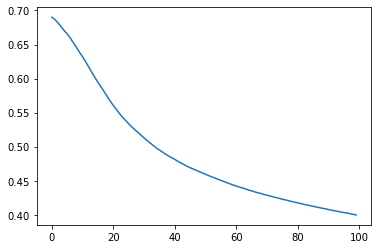

In [174]:
plt.plot(p_t_losses)

In [181]:
embedded_products = products_tags_df['product_id_num'].apply(p_t_model.get_layer('product_embedding'))
# columns = [x for x in range(100)]
# embedded_movie_df = pd.DataFrame(columns = columns)
embedded_products_df = pd.DataFrame()
for data in embedded_products:
    embedded_products_df = embedded_products_df.append(pd.Series(data), ignore_index=True)
print(embedded_products_df.shape)
embedded_products_df

(134, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.035222,-0.059087,0.038357,0.027650,0.094477,0.059201,-0.075424,-0.036322,0.022002,-0.038110,...,-0.008468,-0.025874,-0.042911,0.010439,-0.033132,-0.031016,0.029759,0.038564,-0.073929,0.009071
1,0.036589,-0.067077,0.050892,0.031023,0.101525,0.064526,-0.085934,-0.049003,0.026737,-0.044802,...,-0.003399,-0.030882,-0.044675,0.014224,-0.038155,-0.045197,0.046021,0.035039,-0.063537,0.016889
2,0.044763,-0.067353,0.050986,0.039486,0.095362,0.067101,-0.078520,-0.034535,0.025908,-0.043142,...,-0.000950,-0.026337,-0.039987,0.016985,-0.032305,-0.025377,0.034128,0.045063,-0.070129,0.010135
3,0.039460,-0.058528,0.044722,0.012729,0.092120,0.060373,-0.067339,-0.052277,0.028999,-0.048381,...,0.002088,-0.025905,-0.046753,0.017722,-0.049769,-0.041569,0.045628,0.048033,-0.052095,0.001780
4,0.027345,-0.062885,0.040597,0.018152,0.100246,0.085339,-0.076238,-0.057028,0.025378,-0.047179,...,0.000063,-0.040924,-0.044672,0.002764,-0.046315,-0.041714,0.025870,0.044414,-0.062306,0.002915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.010009,-0.028330,0.074850,-0.012853,0.091097,-0.030209,-0.093241,-0.054770,0.046184,0.021672,...,0.001891,0.006727,-0.063092,0.023970,0.005977,-0.000917,0.010586,0.082324,-0.023301,0.105981
130,-0.025865,-0.085571,0.071962,0.011713,0.091908,0.002216,-0.026303,-0.014709,0.064864,-0.019219,...,0.010486,-0.019986,-0.035715,0.066344,-0.020311,-0.065059,0.006659,-0.001099,0.048853,-0.026401
131,-0.018267,-0.012675,-0.005366,0.020980,0.055920,0.024276,-0.042721,-0.039959,0.021090,-0.015239,...,0.042577,-0.063601,-0.039437,-0.002193,-0.034028,-0.030071,0.042929,0.007711,-0.029000,0.027680
132,0.002134,-0.050103,0.036887,0.018229,0.032676,0.000772,-0.057225,-0.047597,0.033977,-0.038330,...,0.049079,-0.042000,-0.059939,0.032303,-0.017632,-0.043536,0.055813,0.022489,-0.049462,0.069193


In [182]:
# PCA를 이용한 차원 축소
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

product_scaled = StandardScaler().fit_transform(embedded_products_df)
pca = PCA(n_components=2)
pca.fit(product_scaled)
product_pca = pca.transform(product_scaled)
pca_columns=[f'{n}' for n in range(2)]
product_df_pca = pd.DataFrame(product_pca,columns=pca_columns)
product_df_pca = pd.concat([product_df_pca, products_tags_df["Variant SKU"]], axis=1)
product_df_pca = pd.concat([product_df_pca, products_tags_df["description"]], axis=1)
product_df_pca.head()

,0,1,Variant SKU,description
0,3.967932,-2.419495,HOD0772,"ishyablockprintedkurtaset,ishyablockprintedkur..."
1,4.028965,-2.323223,HOD0766,"ahaanablockprintedkurtaset,ahaanablockprintedk..."
2,4.799432,-1.786871,HOD0760,"seherblockprintedkurtaset,seherblockprintedkur..."
3,3.325000,-1.958223,HOD0754,"mihirablockprintedkurtaset,mihirablockprintedk..."
4,5.329153,-2.671635,HOD0748,"baharblockprintedkurtaset,baharblockprintedkur..."


In [186]:
fig = px.scatter(product_df_pca, x='0', y='1', color='Variant SKU')
fig.show()

In [188]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_products_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, products_tags_df["Variant SKU"]], axis=1)
tsne_df = pd.concat([tsne_df, products_tags_df["description"]], axis=1)
tsne_df.head()

,x,y,Variant SKU,description
0,-8.514889,-8.263968,HOD0772,"ishyablockprintedkurtaset,ishyablockprintedkur..."
1,-8.478930,-8.274362,HOD0766,"ahaanablockprintedkurtaset,ahaanablockprintedk..."
2,-8.538480,-8.287774,HOD0760,"seherblockprintedkurtaset,seherblockprintedkur..."
3,-8.481536,-8.304050,HOD0754,"mihirablockprintedkurtaset,mihirablockprintedk..."
4,-8.424252,-8.310059,HOD0748,"baharblockprintedkurtaset,baharblockprintedkur..."


In [189]:
fig = px.scatter(tsne_df, x='x', y='y', color='Variant SKU')
fig.show()

In [192]:
product_layer = p_t_model.get_layer('product_embedding')
product_weights = product_layer.get_weights()[0]
product_weights.shape


(134, 100)

In [194]:
product_weights = product_weights / np.linalg.norm(product_weights, axis = 1).reshape((-1, 1))
product_weights[0][:10]

array([ 0.0885025 , -0.14846888,  0.09637884,  0.06947589,  0.2373914 ,
        0.14875515, -0.18951847, -0.0912651 ,  0.05528521, -0.09575997],
      dtype=float32)

In [195]:
np.sum(np.square(product_weights[0]))

1.0

In [198]:
products_tags_df.head()

,Variant SKU,description,product_id_num,tags
0,HOD0772,"ishyablockprintedkurtaset,ishyablockprintedkur...",0,"[0, 1, 2, 3, 4, 5, 6, 7]"
1,HOD0766,"ahaanablockprintedkurtaset,ahaanablockprintedk...",1,"[8, 9, 2, 3, 4, 5, 6, 7]"
2,HOD0760,"seherblockprintedkurtaset,seherblockprintedkur...",2,"[10, 11, 2, 3, 4, 5, 6, 7]"
3,HOD0754,"mihirablockprintedkurtaset,mihirablockprintedk...",3,"[12, 13, 2, 3, 4, 5, 6, 7]"
4,HOD0748,"baharblockprintedkurtaset,baharblockprintedkur...",4,"[14, 15, 2, 3, 4, 5, 6, 7]"


In [199]:
skulist = products_tags_df['Variant SKU'].tolist()
print(skulist)

['HOD0772', 'HOD0766', 'HOD0760', 'HOD0754', 'HOD0748', 'HOD0742', 'HOD0727', 'HOD0721', 'HOD0715', 'HOD0709', 'HOD0703', 'HOD0697', 'HOD0691', 'HOD0685', 'HOD0679', 'HOD0673', 'HOD0667', 'HOD0663', 'HOD0659', 'HOD0655', 'HOD0651', 'HOD0647', 'HOD0643', 'HOD0639', 'HOD0635', 'HOD0631', 'HOD0627', 'HOD0623', 'HOD0619', 'HOD0615', 'HOD0611', 'HOD0607', 'HOD0603', 'HOD0599', 'HOD0591', 'HOD0587', 'HOD0583', 'HOD0579', 'HOD0575', 'HOD0571', 'HOD0567', 'HOD0563', 'HOD0555', 'HOD0529', 'HOD0523', 'HOD0517', 'HOD0511', 'HOD0505', 'HOD0493', 'HOD0487', 'HOD0481', 'HOD0475', 'HOD0277', 'HOD0271', 'HOD0265', 'HOD0259', 'HOD0253', 'HOD0247', 'HOD0552', 'HOD0241', 'HOD0551', 'HOD0550', 'HOD0235', 'HOD0548', 'HOD0547', 'HOD0229', 'HOD0223', 'HOD0545', 'HOD0544', 'HOD0543', 'HOD0217', 'HOD0542', 'HOD0211', 'HOD0538', 'HOD0205', 'HOD0537', 'HOD0536', 'HOD0199', 'HOD0193', 'HOD0187', 'HOD0181', 'HOD0469', 'HOD0463', 'HOD0457', 'HOD0451', 'HOD0445', 'HOD0439', 'HOD0433', 'HOD0427', 'HOD0421', 'HOD0415'

In [201]:
product_index = {sku: idx for idx, sku in enumerate(skulist)}

In [203]:
product_index['HOD0679']

14

In [205]:
index_product = {idx: sku for sku, idx in product_index.items()}

In [207]:
index_product[14]

'HOD0679'

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'sku', n = 10):
    """Find n most similar items (or least) to name based on embeddings."""
    
    if index_name == 'sku':
        index = product_index
        rindex = index_product

    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    
    
   
    # Take the last n sorted distances
    closest = sorted_dists[-n:]

    print(f'{index_name.capitalize()}s closest to {name}.\n')
        
   
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')
        

In [213]:
find_similar('HOD0679', product_weights)

Skus closest to HOD0679.

Sku: HOD0679   Similarity: 1.0
Sku: HOD0667   Similarity: 0.95
Sku: HOD0691   Similarity: 0.95
Sku: HOD0715   Similarity: 0.95
Sku: HOD0721   Similarity: 0.95
Sku: HOD0685   Similarity: 0.93
Sku: HOD0673   Similarity: 0.92
Sku: HOD0727   Similarity: 0.92
Sku: HOD0709   Similarity: 0.91
Sku: HOD0697   Similarity: 0.91
